<a href="https://colab.research.google.com/github/wonjae124/Capston/blob/colab/Complete_Petfinder_binary_widedeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path) ## 소프트 link 파일 혹은 폴더를 만들 때 사용
sys.path.insert(0, my_path)
#https://teddylee777.github.io/colab/colab%EC%97%90%EC%84%9C-python%ED%8C%A8%ED%82%A4%EC%A7%80%EB%A5%BC-permanently-%EC%9D%B8%EC%8A%A4%ED%86%A8%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95

!pip install --target=$my_path pytorch-widedeep
!pip install --target=$my_path git+https://github.com/jrzaurin/pytorch-widedeep.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: ignored

In [25]:
pip install git+https://github.com/jrzaurin/pytorch-widedeep.git


  Cloning https://github.com/jrzaurin/pytorch-widedeep.git to /tmp/pip-req-build-k00770a7
  Running command git clone -q https://github.com/jrzaurin/pytorch-widedeep.git /tmp/pip-req-build-k00770a7
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 104, in resolve
    req, requested_extras=()
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/factory.py", line 434, in make_requirement_from_install_req
    ver

In [26]:
!git clone https://github.com/jrzaurin/pytorch-widedeep
!cd pytorch-widedeep

fatal: destination path 'pytorch-widedeep' already exists and is not an empty directory.


In [27]:
!pip install -e .


ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: /content


In [28]:
import pandas as pd
import numpy as np
import torch
import time
from io import StringIO

from sklearn.model_selection import train_test_split

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.metrics import Accuracy, Precision, Recall, F1Score
from pytorch_widedeep.datasets import load_adult


In [29]:
df = pd.read_csv('/content/drive/MyDrive/Wide_deep/train_0406.csv') #  index_col=[0],
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df = df.fillna('?')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           14993 non-null  object
 1   Name           14993 non-null  object
 2   Age            14993 non-null  int64 
 3   Breed1         14993 non-null  object
 4   Breed2         14993 non-null  object
 5   Gender         14993 non-null  object
 6   Color1         14993 non-null  object
 7   Color2         14993 non-null  object
 8   Color3         14993 non-null  object
 9   MaturitySize   14993 non-null  object
 10  FurLength      14993 non-null  object
 11  Vaccinated     14993 non-null  object
 12  Dewormed       14993 non-null  object
 13  Sterilized     14993 non-null  object
 14  Health         14993 non-null  object
 15  Quantity       14993 non-null  int64 
 16  Fee            14993 non-null  int64 
 17  Description    14993 non-null  object
 18  PetID          14993 non-n

In [30]:
# df[['AdoptionSpeed']] = df[['AdoptionSpeed']].astype(object)

In [31]:
df[['AdoptionSpeed_label']] = (df[["AdoptionSpeed"]].apply(lambda x : 1 in x)).astype(int) # Return_to_Owner에 대한 이진분류 실행 예정

In [32]:
df.AdoptionSpeed_label

0        1
1        1
2        1
3        1
4        1
        ..
14988    1
14989    1
14990    1
14991    1
14992    1
Name: AdoptionSpeed_label, Length: 14993, dtype: int64

In [33]:
condition = (df.AdoptionSpeed  == 0)
df[condition]

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Dewormed,Sterilized,Health,Quantity,Fee,Description,PetID,AdoptionSpeed,DataType,AdoptionSpeed_label
1,Cat,?,1,Domestic medium hair,0,Male,Black,Brown,?,Medium,...,Not sure,Not sure,Healthy,1,0,I just found it alone yesterday near my apartm...,6296e909a,0,train,1
75,Dog,Coco,2,Mixed breeds,0,Female,Brown,Cream,?,Medium,...,Yes,No,Healthy,1,0,Hi Coco is a rescued puppy from the streets. I...,259b10a3e,0,train,1
106,Cat,SYLVESTER,1,Domestic short hair,Domestic short hair,Neutered/Spayed,Black,White,?,Medium,...,Yes,No,Healthy,2,1,"Kittens found living at restaurant, with sibli...",19b1f4263,0,train,1
170,Cat,Sunset,2,Ibizan Hound,252,Male,Brown,Cream,?,Small,...,No,No,Healthy,1,0,*** Looking for someone who really love and ad...,b9590d4de,0,train,1
259,Dog,Chanelle,18,Ibizan Hound,Mixed breeds,Female,Brown,White,?,Medium,...,Yes,Yes,Healthy,1,0,Chanelle found a home!,1c59cecac,0,train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14866,Cat,Cotton,16,285,Domestic short hair,Male,Cream,?,?,Large,...,No,Yes,Healthy,1,0,We have been looking after Cotton since he was...,72ae87d2b,0,train,1
14907,Dog,Milo,10,190,Mixed breeds,Male,Brown,White,?,Medium,...,Yes,No,Healthy,1,0,"Milo is a male, St. Bernard mixed. We're looki...",03f217352,0,train,1
14923,Dog,Lab Mix 3,2,Mixed breeds,141,Female,Brown,?,?,Medium,...,Yes,No,Healthy,1,0,Same puppy as previous posting. This posting i...,6097a5c1d,0,train,1
14952,Cat,Abg Long,12,243,Ibizan Hound,Male,Gray,White,?,Medium,...,Yes,No,Minor Injury,1,0,kucing pertama yg kami selamatkan.. jatuh dlm ...,26a07719d,0,train,1


In [34]:
df[['AdoptionSpeed_label']]=(df[['AdoptionSpeed']]==0).astype(int)

In [35]:
# df = load_adult(as_frame=True)
# df["income_label"] = (df["income"].apply(lambda x: ">50k" in x)).astype(int)
# df.fillna('?')
# df.info()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Type                 14993 non-null  object
 1   Name                 14993 non-null  object
 2   Age                  14993 non-null  int64 
 3   Breed1               14993 non-null  object
 4   Breed2               14993 non-null  object
 5   Gender               14993 non-null  object
 6   Color1               14993 non-null  object
 7   Color2               14993 non-null  object
 8   Color3               14993 non-null  object
 9   MaturitySize         14993 non-null  object
 10  FurLength            14993 non-null  object
 11  Vaccinated           14993 non-null  object
 12  Dewormed             14993 non-null  object
 13  Sterilized           14993 non-null  object
 14  Health               14993 non-null  object
 15  Quantity             14993 non-null  int64 
 16  Fee 

In [37]:
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Dewormed,Sterilized,Health,Quantity,Fee,Description,PetID,AdoptionSpeed,DataType,AdoptionSpeed_label
0,Cat,Nibble,3,Tabby,0,Male,Black,White,?,Small,...,No,No,Healthy,1,100,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,2,train,0
1,Cat,?,1,Domestic medium hair,0,Male,Black,Brown,?,Medium,...,Not sure,Not sure,Healthy,1,0,I just found it alone yesterday near my apartm...,6296e909a,0,train,1
2,Dog,Brisco,1,Mixed breeds,0,Male,Brown,White,?,Medium,...,Yes,No,Healthy,1,0,Their pregnant mother was dumped by her irresp...,3422e4906,3,train,0
3,Dog,Miko,4,Mixed breeds,0,Female,Black,Brown,?,Medium,...,Yes,No,Healthy,1,150,"Good guard dog, very alert, active, obedience ...",5842f1ff5,2,train,0
4,Dog,Hunter,1,Mixed breeds,0,Male,Black,?,?,Medium,...,No,No,Healthy,1,0,This handsome yet cute boy is up for adoption....,850a43f90,2,train,0


In [38]:
df_train, df_test = train_test_split(df, test_size = 0.2, stratify = df.AdoptionSpeed_label)

In [39]:
wide_cols = [
             "Type",
             "Name",
             "Breed1",
             "Color1",
             "Health", 
             "Vaccinated",
             "Dewormed",                        
] #wide part는 memorization 담당(고정요소. 타고 태어난 요소)

In [40]:
crossed_cols = [("Vaccinated","Health"),("Dewormed","Health")] # 얼만큼 가중치를 줄지 정할 수 있다.

cat_embed_cols = [   
             "Type",                   
             "MaturitySize",                  
             "Health",   
             "Breed1",               
             "Color1",                              
             "Name",                  
             "Dewormed",                  
             "Sterilized",                    
             "Gender",         
             "FurLength",
             "Vaccinated",
]  # deep part는 Generalization 담당(고정요소 + 변동 요소)

continuous_cols = ["Fee","Age"] 

target = 'AdoptionSpeed_label' 
target = df_train[target].values

In [41]:
wide_preprocessor = WidePreprocessor(wide_cols = wide_cols, crossed_cols = crossed_cols) #????
X_wide = wide_preprocessor.fit_transform(df_train) # 왜이렇게 많이 뭔가 전처리 하지?

tab_preprocessor = TabPreprocessor(
    cat_embed_cols = cat_embed_cols, continuous_cols= continuous_cols
)

X_tab = tab_preprocessor.fit_transform(df_train)

In [42]:
wide = Wide(input_dim=np.unique(X_wide).shape[0], pred_dim = 1) #TODO. pred_dim을 multi_classification에서는 내가 사용할 class 개수로 바꾸는건가?....
tab_mlp = TabMlp(
    column_idx = tab_preprocessor.column_idx,
    cat_embed_input = tab_preprocessor.cat_embed_input,
    cat_embed_dropout=0.1,
    continuous_cols = continuous_cols,
    mlp_hidden_dims=[400, 200],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",    
)

model = WideDeep(wide = wide, deeptabular = tab_mlp)

In [43]:
model

WideDeep(
  (wide): Wide(
    (wide_linear): Embedding(7690, 1, padding_idx=0)
  )
  (deeptabular): Sequential(
    (0): TabMlp(
      (cat_and_cont_embed): DiffSizeCatAndContEmbeddings(
        (cat_embed): DiffSizeCatEmbeddings(
          (embed_layers): ModuleDict(
            (emb_layer_Type): Embedding(3, 2, padding_idx=0)
            (emb_layer_MaturitySize): Embedding(5, 3, padding_idx=0)
            (emb_layer_Health): Embedding(4, 3, padding_idx=0)
            (emb_layer_Breed1): Embedding(167, 28, padding_idx=0)
            (emb_layer_Color1): Embedding(8, 5, padding_idx=0)
            (emb_layer_Name): Embedding(7488, 236, padding_idx=0)
            (emb_layer_Dewormed): Embedding(4, 3, padding_idx=0)
            (emb_layer_Sterilized): Embedding(4, 3, padding_idx=0)
            (emb_layer_Gender): Embedding(4, 3, padding_idx=0)
            (emb_layer_FurLength): Embedding(4, 3, padding_idx=0)
            (emb_layer_Vaccinated): Embedding(4, 3, padding_idx=0)
          )
   

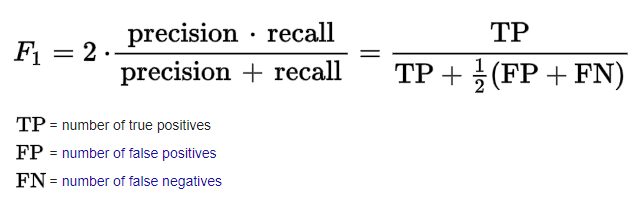 

출처 : https://for-my-wealthy-life.tistory.com/6 

In [44]:
trainer = Trainer(model, 
                  objective = "binary", 
                  optimizers = torch.optim.AdamW(model.parameters(),lr = 0.01),
                  metrics = [F1Score] #Accuracy ,Precision, Recall,
                  #https://sumniya.tistory.com/26
                  #Precision 모델이 True로 예측한 것 중에 실제 True로 검증 된 것 
                  #Recall(재현율) 실제 True인 것 중에 모델도 True로 예측한 것
                  ) # TODO. multi_classification에서는 object를 multiclass로 부른다. 
                                                                      # Optimizer default는 Adam이다.
                                                                      # deepimage 쓸 떄는 transforms 써도 된다.
                                                                      # Accuracy가 100%에 수렴하므로 precision으로 변경 함

# 앗! 여기서 obejctive 말고 다른 것을 할 수 있겠다.
# 그런데, 검증 함수 그런건 어딨냐?.. 아까 있었는데

start = time.time()


trainer.fit(
    X_wide=X_wide,
    X_tab = X_tab,
    target = target,
    n_epochs = 50,
    batch_size = 256,
    val_split=0.2
)

end = time.time()
total_time = (end-start)/60

print("excution_time : {:.1f}min".format(total_time))

valid: 100%|██████████| 10/10 [00:00<00:00, 42.32it/s, loss=0.629, metrics={'f1': 0.0497}]

excution_time : 1.2min


In [45]:
print(torch.__version__)

1.11.0+cu102


In [46]:
X_wide_te = wide_preprocessor.transform(df_test) #wide랑 tab이랑 무슨 차이지?
X_tab_te = tab_preprocessor.transform(df_test)
preds = trainer.predict(X_wide = X_wide_te, X_tab = X_tab_te) #한쪽은 정답이고 한쪽은 입력 아닌가?

predict: 100%|██████████| 12/12 [00:00<00:00, 60.70it/s]


In [47]:
#trainer와 torch는 무슨 차이지?
# Option 1: this will also save training history and lr history if the

trainer.save(path="model_weights", save_state_dict = True)

# Option 2: save as any other torch model

torch.save(model.state_dict(), "model_weights/wd_model.pt") # 이게 도대체 뭐야? 허허... 왜 파일 확장자가 pt인거지?

model_new = WideDeep(wide = wide, deeptabular = tab_mlp) # wide랑 tab_mlp랑 왜 따로 트랜스폼 해두었을까?

model_new.load_state_dict(torch.load("model_weights/wd_model.pt")) 

trainer_new = Trainer(model_new, objective = 'binary') #trainer는 언제 만들어서 언제 활용했지?

preds = trainer_new.predict(X_wide=X_wide, X_tab = X_tab)

predict: 100%|██████████| 47/47 [00:00<00:00, 96.89it/s] 


In [48]:
!pytest tests

============================= test session starts ==============================
platform linux -- Python 3.7.13, pytest-3.6.4, py-1.11.0, pluggy-0.7.1
rootdir: /content, inifile:
plugins: typeguard-2.7.1

========================= no tests ran in 0.00 seconds =========================
ERROR: file not found: tests

